In [1]:
# necessary python modules

from tqdm import tqdm
import numpy as np
import math
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import kn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl        
mpl.rcParams['text.usetex'] = True
import seaborn
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

pal = seaborn.color_palette("tab10")
print(pal.as_hex())

# if seaborn does not work, try: pip install seaborn

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [2]:
#check which interaction is used and save fig in the appropriate subfolder

NN_int = True

fv = 'NN'  if NN_int == True else 'd' if NN_int == False else None

path_dict = {
    'd': "C:\\Users\\camipolv\\Desktop\\dipbec\\fig\\dipnb\\",
    'NN': "C:\\Users\\camipolv\\Desktop\\dipbec\\fig\\NNnb\\"
}

fpath = path_dict.get(fv, "Default path")

Ust = r"$U_{NN}$" if fv == "NN" else r"$U_d$" if fv == "d" else None
Ucs = r"$/U_c$"

In [10]:
#parameters

Ndisr = 1000
Nmesh = 1000

N0 = 3 
#N1 = 10
#N2 = 100
#N3 = 500

kx_small = 0.1 
kx_large_dict = {'d': 10.0, 'NN': 25.0}
kx_large = kx_large_dict.get(fv, "Default value")

Uc = 1.0

#NN: Ud << Uc/2, d: Ud << Uc/3
Ud1_dict = {'d': 0.0, 'NN': 0.0}
Ud2_dict = {'d': 0.1, 'NN': 0.1}
Ud3_dict = {'d': 0.3, 'NN': 0.3}
Ud1 = Ud1_dict.get(fv, "Default value")
Ud2 = Ud2_dict.get(fv, "Default value")
Ud3 = Ud3_dict.get(fv, "Default value")

sigma1 = 0.0
sigma2 = 0.2
sigma3 = 0.5

t0 = 1.0
t1 = 2.0
t2 = 5.0
t3 = 10.0

t_dict = {'d': np.arange(0, t2, .1), 'NN': np.arange(0, t1, .01)}
tdar = t_dict.get(fv, "Default value")

kxs = [kx_small, kx_large]
kxar = np.linspace(kx_small, kx_large, Nmesh)
sigmas = [sigma1, sigma2, sigma3]
Sigmar = np.linspace(sigma1, sigma3, 10)
Uds = [Ud1, Ud2, Ud3]
Udar = np.linspace(Ud1, Ud3, 10)
Ntar = np.asarray([2, 4, 6, 8, 10])

markers = ['s', 'o', '^']

print(Ndisr)
print(Ust + r" = {}, {}, {}".format(Ud1, Ud2, Ud3))
print(f"kx = {kx_small}, {kx_large}")
print(tdar)

1000
$U_{NN}$ = 0.0, 0.1, 0.3
kx = 0.1, 25.0
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1

In [4]:
#riemann sum integration - used for the viscosity
def intg(kxar,far):
    intg = (kxar[-1]-kxar[0])*np.sum(far)/len(kxar)
    return intg

def norm(vec, Ntubes):
		identity_matrix_n = np.eye(Ntubes)
		zero_matrix_n = np.zeros((Ntubes, Ntubes))
		s3n = np.block([[identity_matrix_n, zero_matrix_n],[zero_matrix_n, -identity_matrix_n]])
		normalization = np.sqrt(np.einsum('ij,ij->j', vec, np.matmul(s3n, vec)))
		#print('check state normalization:', normalization)
		vec = vec / normalization
		#print('check state normalization:', np.sqrt(np.einsum('ij,ij->j', vec, np.matmul(s3n, vec))))
		return vec

def valvec(Hk):
	val, vec = np.linalg.eig(Hk)
	mask = np.logical_or(np.round(val.real,10)>0,np.round(val.imag,10)>0)
	val = val[mask]
	vec = vec[:, mask]
	idx = val.argsort()
	val = val[idx]
	vec = vec[:, idx]
	return val, vec

def makeBogoMat(Ntubes, kx, Uc, Ud, nb):
		# given an array of Boson densities, make the Bogo Matrix
		h_1 = np.zeros( [Ntubes, Ntubes] )
		h_2 = np.zeros( [Ntubes, Ntubes] )

		for i in range(Ntubes):
			for j in range(Ntubes):
				if ( i==j ):
					h_1[i,j] = (kx**2)/(2.0) + Uc*nb[i]
					h_2[i,j] = Uc*nb[i]
				else:
					if NN_int:
						if (abs(i-j)<2): #Nearest neighbor dipolar interaction
							h_1[i,j] = Ud*(math.sqrt(nb[i]*nb[j]))
							h_2[i,j] = Ud*(math.sqrt(nb[i]*nb[j]))
					else: #1/x^3 dipolar interaction
						h_1[i,j] = Ud*(math.sqrt(nb[i]*nb[j]))*2*kx*kn(1,abs(i-j)*kx)/(abs(i-j))
						h_2[i,j] = Ud*(math.sqrt(nb[i]*nb[j]))*2*kx*kn(1,abs(i-j)*kx)/(abs(i-j))

		Haml = np.block([[h_1,h_2],[-h_2,-h_1]])

		return Haml

def BogUV(Ntubes, kx, Uc, Ud, nb):
	# given the Bogo matrix, we extract the U and V matrices from its eigenvectors
    identity_matrix_n = np.eye(Ntubes)
    zero_matrix_n = np.zeros((Ntubes, Ntubes))
    s3n = np.block([[identity_matrix_n, zero_matrix_n],[zero_matrix_n, -identity_matrix_n]]) #s3n is the n-dim pauli matrix sigmaz
    pn = np.block([[zero_matrix_n, identity_matrix_n],[1*identity_matrix_n, zero_matrix_n]]) #pn is the n-dim parity matrix
    ham = makeBogoMat(Ntubes, kx, Uc, Ud, nb)
	#Normalize the eigenvectors wrt matrix s3n using broadcasting
    val, vec = valvec(ham)
    vec = norm(vec, Ntubes)
    #for i in range(vec.shape[1]): #normalize the eigenvectors wrt matrix s3n
        #vec[:, i] = vec[:, i] / np.sqrt(np.matmul(vec[:, i].T, np.matmul(s3n, vec_s[:, i])))
    pvec = np.matmul(pn, np.conj(vec)) #define bottom half of eigenvectors through the parity matrix pn
    vec_s = np.concatenate((vec, pvec), axis=1)		
    U = vec_s[0:Ntubes, 0:Ntubes]
    V = vec_s[Ntubes:, 0:Ntubes]
    #T = np.block([[U, V], [np.conj(V), np.conj(U)]])
    #np.set_printoptions(precision=2, suppress=True)
    return val,U,V

def eta_yyp(Ntubes, kx, Uc, Ud, nb, y, yp): 
	val_s, U, V = BogUV(Ntubes, kx, Uc, Ud, nb)
	int_k = 0

	for i in range(1,Ntubes + 1):
		for j in range(1,Ntubes + 1):
			term_uuvv = U[y-1,i-1]*np.conj(U[yp-1,i-1])*V[y-1,j-1]*np.conj(V[yp-1,j-1])
			term_uvvu = U[y-1,i-1]*np.conj(V[yp-1,i-1])*V[y-1,j-1]*np.conj(U[yp-1,j-1])
			int_k += -2*(kx**2)*(term_uuvv - term_uvvu)

	return int_k

def eta0_yyp(Ntubes, kx, Uc, Ud, nb, y, yp): 
	val_s, U, V = BogUV(Ntubes, kx, Uc, Ud, nb)
	int_k = 0

	for i in range(1,Ntubes + 1):
		for j in range(1,Ntubes + 1):
			term_uuvv = U[y-1,i-1]*np.conj(U[yp-1,i-1])*V[y-1,j-1]*np.conj(V[yp-1,j-1])
			term_uvvu = U[y-1,i-1]*np.conj(V[yp-1,i-1])*V[y-1,j-1]*np.conj(U[yp-1,j-1])
			int_k += -2*(kx**2)*(term_uuvv - term_uvvu)*(val_s[i-1] + val_s[j-1] )

	return int_k

def eta_yyp_t(Ntubes, kx, Uc, Ud, nb, y, yp, t):
	val_s, U, V = BogUV(Ntubes, kx, Uc, Ud, nb)
	int_k = 0

	for i in range(1,Ntubes + 1):
		for j in range(1,Ntubes + 1):
			term_uuvv = U[y-1,i-1]*np.conj(U[yp-1,i-1])*V[y-1,j-1]*np.conj(V[yp-1,j-1])
			term_uvvu = U[y-1,i-1]*np.conj(V[yp-1,i-1])*V[y-1,j-1]*np.conj(U[yp-1,j-1])
			int_k += -2*(kx**2)*(term_uuvv - term_uvvu)*np.sin( (val_s[i-1] + val_s[j-1] )*t)

	return int_k

def etaDisr(Ndisr, Ntubes, kx, Uc, Ud, sigma, y, yp):
	visc = []
	nb = np.random.uniform(1-sigma, 1+sigma, Ntubes)
	for i in range(Ndisr):
		# force that sum is Ntubes
		offset = np.sum(nb) - Ntubes 
		nb = nb - offset/Ntubes
		# get the ipr
		visc.append(eta_yyp(Ntubes, kx, Uc, Ud, nb, y, yp))

	return np.mean(visc)

def etaHist(Ndisr, Ntubes, kx, Uc, Ud, sigma, y, yp):
	visc = []
	nb = np.random.uniform(1-sigma, 1+sigma, Ntubes)
	for i in range(Ndisr):
		# force that sum is Ntubes
		offset = np.sum(nb) - Ntubes 
		nb = nb - offset/Ntubes
		# get the ipr
		visc.append(eta_yyp(Ntubes, kx, Uc, Ud, nb, y, yp))

	# Plot the histogram
	plt.hist(visc, bins=30, edgecolor='black')
	plt.title('Histogram of visc values')
	plt.xlabel('Value')
	plt.ylabel('Frequency')
	plt.show()

def eta0Disr(Ndisr, Ntubes, kx, Uc, Ud, sigma, y, yp):
	visc = []
	nb = np.random.uniform(1-sigma, 1+sigma, Ntubes)
	for i in range(Ndisr):
		# force that sum is Ntubes
		offset = np.sum(nb) - Ntubes 
		nb = nb - offset/Ntubes
		# get the ipr
		visc.append(eta0_yyp(Ntubes, kx, Uc, Ud, nb, y, yp))

		return np.mean(visc)
	
def eta0Hist(Ndisr, Ntubes, kx, Uc, Ud, sigma, y, yp):
	visc = []
	nb = np.random.uniform(1-sigma, 1+sigma, Ntubes)
	for i in range(Ndisr):
		# force that sum is Ntubes
		offset = np.sum(nb) - Ntubes 
		nb = nb - offset/Ntubes
		# get the ipr
		visc.append(eta0_yyp(Ntubes, kx, Uc, Ud, nb, y, yp))
	print(visc)
	# Plot the histogram
	plt.hist(visc, bins=30, edgecolor='black')
	plt.title('Histogram of visc values')
	plt.xlabel('Value')
	plt.ylabel('Frequency')
	plt.show()

def etatDisr(Ndisr, Ntubes, kx, Uc, Ud, sigma, y, yp, t):
	visc = []
	nb = np.random.uniform(1-sigma, 1+sigma, Ntubes)
	for i in range(Ndisr):
		# force that sum is Ntubes
		offset = np.sum(nb) - Ntubes 
		nb = nb - offset/Ntubes
		# get the ipr
		visc.append(eta_yyp_t(Ntubes, kx, Uc, Ud, nb, y, yp, t))

	return np.mean(visc)

def etatHist(Ndisr, Ntubes, kx, Uc, Ud, sigma, y, yp, t):
	visc = []
	nb = np.random.uniform(1-sigma, 1+sigma, Ntubes)
	for i in range(Ndisr):
		# force that sum is Ntubes
		offset = np.sum(nb) - Ntubes 
		nb = nb - offset/Ntubes
		# get the ipr
		visc.append(eta_yyp_t(Ntubes, kx, Uc, Ud, nb, y, yp, t))

	# Plot the histogram
	plt.hist(visc, bins=30, edgecolor='black')
	plt.title('Histogram of visc values')
	plt.xlabel('Value')
	plt.ylabel('Frequency')
	plt.show()

In [5]:
# eta integrand vs kx for 3 values of Ud, at fix sigma and N 

Ntubes = N0
sigma = sigmas[1]

etak_3u = [[] for _ in range(len(Uds))]

for kx in tqdm(kxar):
    for i, u in enumerate(Uds):
        etak_3u[i].append(etaDisr(Ndisr, Ntubes, kx, Uc, u, sigma, 1, Ntubes))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s]


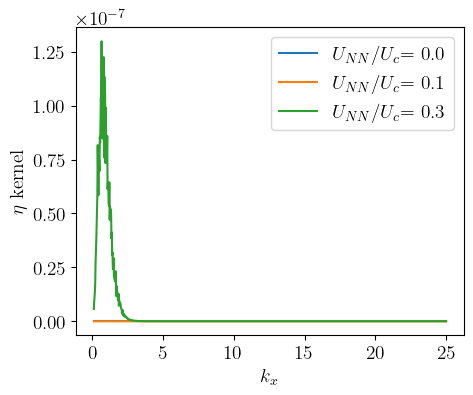

In [6]:
plt.figure(figsize=(5,4))

for i in range(len(Uds)):
    plt.plot(kxar, etak_3u[i], label=Ust+Ucs+r'= {}'.format(Uds[i]))#, marker=markers[i])

plt.xlabel(r"$k_x$", fontsize=14)
plt.ylabel(r"$\eta$ kernel", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [11]:
# eta0 integrand vs kx for 3 values of Ud, at fix sigma and N 

Ntubes = N0
sigma = sigmas[1]

eta0k_3u = [[] for _ in range(len(Uds))]

for kx in tqdm(kxar):
    for i, u in enumerate(Uds):
        eta0k_3u[i].append(eta0Disr(Ndisr, Ntubes, kx, Uc, u, sigma, 1, Ntubes))

100%|██████████| 1000/1000 [00:00<00:00, 1291.38it/s]


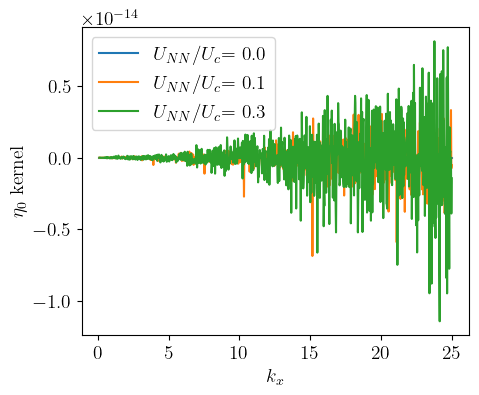

In [12]:
plt.figure(figsize=(5,4))

for i in range(len(Uds)):
    plt.plot(kxar, eta0k_3u[i], label=Ust+Ucs+r'= {}'.format(Uds[i]))#, marker=markers[i])

plt.xlabel(r"$k_x$", fontsize=14)
plt.ylabel(r"$\eta_0$ kernel", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [13]:
# eta integrand vs kx for 3 values of sigma, at fix Ud and N 

Ntubes = N0
Ud = Uds[1]

eta_kx = [[] for _ in range(len(sigmas))]

for i, s in enumerate(sigmas):
    for kx in tqdm(kxar):
        eta_kx[i].append(np.abs(etaDisr(Ndisr, Ntubes, kx, Uc, Ud, s, 1, Ntubes)))

 36%|███▋      | 364/1000 [01:50<03:13,  3.29it/s]


KeyboardInterrupt: 

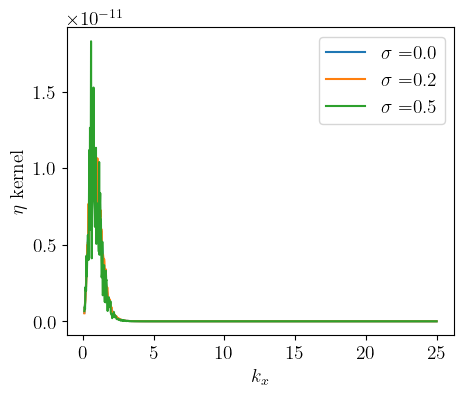

In [ ]:
plt.figure(figsize=(5,4))

for i in range(len(sigmas)):
    plt.plot(kxar, eta_kx[i], label=r'$\sigma=${}'.format(sigmas[i]))#, marker=markers[i])

plt.xlabel(r"$k_x$", fontsize=14)
plt.ylabel(r"$\eta$ kernel", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [ ]:
# eta0 integrand vs kx for 3 values of sigma, at fix Ud and N 

Ntubes = N0
Ud = Uds[1]

eta0_kx = [[] for _ in range(len(sigmas))]

for i, s in enumerate(sigmas):
    for kx in tqdm(kxar):
        eta0_kx[i].append(eta0Disr(Ndisr, Ntubes, kx, Uc, Ud, s, 1, Ntubes))

100%|██████████| 1000/1000 [00:00<00:00, 1839.20it/s]


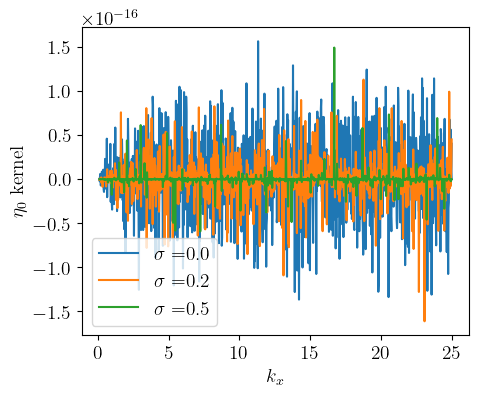

In [ ]:
plt.figure(figsize=(5,4))

for i in range(len(sigmas)):
    plt.plot(kxar, eta0_kx[i], label=r'$\sigma=${}'.format(sigmas[i]))#, marker=markers[i])

plt.xlabel(r"$k_x$", fontsize=14)
plt.ylabel(r"$\eta_0$ kernel", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [ ]:
# eta vs Ud/Uc for 3 values of sigma, at fixed N and t

Ntubes = N0

etau_3s = [[] for _ in range(len(sigmas))]
visc_kx_all = [[[] for _ in range(len(sigmas))] for _ in range(len(Udar))]

# Precompute visc_kx for all u and s
for i, u in enumerate(Udar):
    for j, s in enumerate(sigmas):
        for kx in tqdm(kxar):
            visc_kx_all[i][j].append(etaDisr(Ndisr, Ntubes, kx, Uc, u, s, 1, Ntubes))

# Compute etau_3s
for j, s in enumerate(sigmas):
    for i, u in enumerate(Udar):
        etau_3s[j].append(np.trapz(visc_kx_all[i][j], kxar))

 10%|▉         | 99/1000 [00:00<00:00, 984.66it/s]

 72%|███████▏  | 716/1000 [00:00<00:00, 1692.01it/s]


KeyboardInterrupt: 

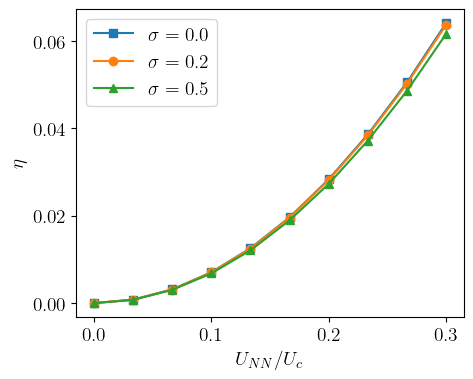

In [ ]:
plt.figure(figsize=(5,4))

for i in range(len(etau_3s)):
    plt.plot(Udar, etau_3s[i], label=r'$\sigma = {}$'.format(sigmas[i]), marker=markers[i])

plt.xlabel(Ust+Ucs, fontsize=14)
plt.ylabel(r"$\eta$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [ ]:
# eta0 vs Ud/Uc for 3 values of sigma, at fixed N and t

Ntubes = N0

eta0u_3s = [[] for _ in range(len(sigmas))]
visc_kx_all = [[[] for _ in range(len(sigmas))] for _ in range(len(Udar))]

# Precompute visc_kx for all u and s
for i, u in enumerate(Udar):
    for j, s in enumerate(sigmas):
        for kx in tqdm(kxar):
            visc_kx_all[i][j].append(eta0Disr(Ndisr, Ntubes, kx, Uc, u, s, 1, Ntubes))

# Compute eta0u_3s
for j, s in enumerate(sigmas):
    for i, u in enumerate(Udar):
        eta0u_3s[j].append(np.trapz(visc_kx_all[i][j], kxar))

100%|██████████| 1000/1000 [00:00<00:00, 2560.87it/s]


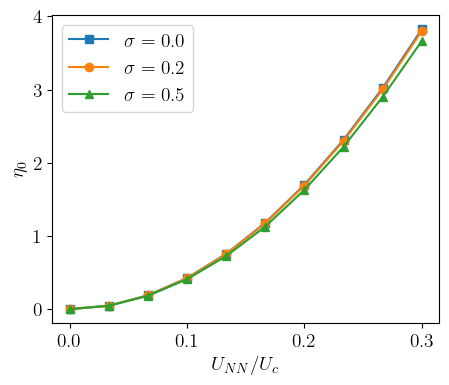

In [ ]:
plt.figure(figsize=(5,4))

for i in range(len(eta0u_3s)):
    plt.plot(Udar, eta0u_3s[i], label=r'$\sigma = {}$'.format(sigmas[i]), marker=markers[i])

plt.xlabel(Ust+Ucs, fontsize=14)
plt.ylabel(r"$\eta_0$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [ ]:
# eta vs sigma for for 3 values of Ud, at fixed Ntubes and t

Ntubes = N0

etas_3u = [[] for _ in range(len(Uds))]
visc_kx_all = [[[] for _ in range(len(Sigmar))] for _ in range(len(Uds))]

# Precompute visc_kx for all s and u
for j, u in enumerate(Uds):
    for i, s in enumerate(Sigmar):
        for kx in tqdm(kxar):
            visc_kx_all[j][i].append(etaDisr(Ndisr, Ntubes, kx, Uc, u, s, 1, Ntubes))

# Compute etas_3u
for j, u in enumerate(Uds):
    for i, s in enumerate(Sigmar):
        etas_3u[j].append(np.trapz(visc_kx_all[j][i], kxar))

100%|██████████| 1000/1000 [00:00<00:00, 3863.67it/s]


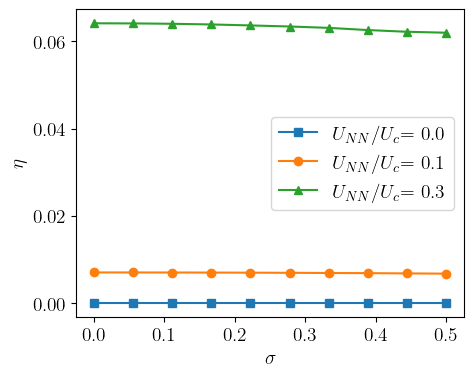

In [ ]:
plt.figure(figsize=(5,4))

for i in range(len(etas_3u)):
    plt.plot(Sigmar, etas_3u[i], label=Ust+Ucs+r'= {}'.format(Uds[i]), marker=markers[i])

plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel(r"$\eta$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [ ]:
# eta0 vs sigma for for 3 values of Ud, at fixed Ntubes and t

Ntubes = N0

eta0s_3u = [[] for _ in range(len(Uds))]
visc_kx_all = [[[] for _ in range(len(Sigmar))] for _ in range(len(Uds))]

# Precompute visc_kx for all s and u
for j, u in enumerate(Uds):
    for i, s in enumerate(Sigmar):
        for kx in tqdm(kxar):
            visc_kx_all[j][i].append(eta0Disr(Ndisr, Ntubes, kx, Uc, u, s, 1, Ntubes))

# Compute eta0s_3u
for j, u in enumerate(Uds):
    for i, s in enumerate(Sigmar):
        eta0s_3u[j].append(np.trapz(visc_kx_all[j][i], kxar))

100%|██████████| 1000/1000 [00:00<00:00, 3189.38it/s]


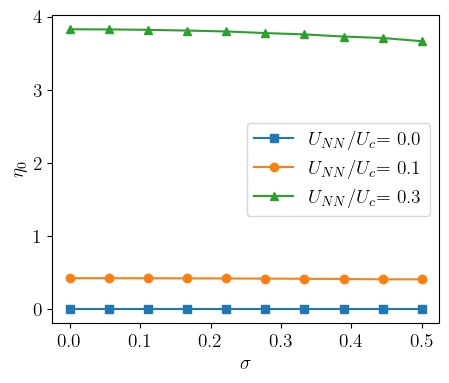

In [ ]:
plt.figure(figsize=(5,4))

for i in range(len(eta0s_3u)):
    plt.plot(Sigmar, eta0s_3u[i], label=Ust+Ucs+r'= {}'.format(Uds[i]), marker=markers[i])

plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel(r"$\eta_0$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [ ]:
# eta vs t for 3 Ud, at fix sigma and N

Ntubes = N0
sigma = sigmas[1]

eta_3u = [[] for _ in range(len(Uds))]
etat_3u = [[] for _ in range(len(Uds))]
visc0_kx = [[] for _ in range(len(Uds))]
visc_kx_all = [[[] for _ in range(len(tdar))] for _ in range(len(Uds))]

# Precompute visc0_kx
for i, u in enumerate(Uds):
    for kx in tqdm(kxar):
        visc0_kx[i].append(eta0Disr(Ndisr, Ntubes, kx, Uc, u, sigma, 1, Ntubes))

# Precompute visc_kx for all t and u
for j, u in enumerate(Uds):
    for i, t in enumerate(tdar):
        for kx in tqdm(kxar):
            visc_kx_all[j][i].append(etatDisr(Ndisr, Ntubes, kx, Uc, u, sigma, 1, Ntubes, t))

# Compute eta_3u and etat_3u
for j, u in enumerate(Uds):
    for i, t in enumerate(tdar):
        eta_3u[j].append(np.trapz(visc_kx_all[j][i], kxar) / np.trapz(visc0_kx[1], kxar))
        etat_3u[j].append(np.trapz(visc_kx_all[j][i], kxar))

100%|██████████| 1000/1000 [00:00<00:00, 3343.18it/s]


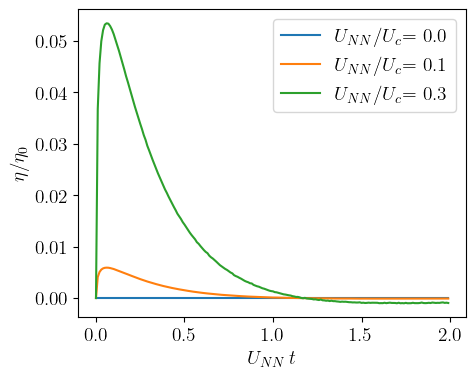

In [ ]:
plt.figure(figsize=(5,4))

for i in range(len(etat_3u)):
    plt.plot(tdar, eta_3u[i], label=Ust+Ucs+r'= {}'.format(Uds[i]))

plt.xlabel(Ust+r"$\,t$", fontsize=14)
plt.ylabel(r"$\eta/\eta_0$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [ ]:
# eta vs t for 3 sigma, fixed Ud and N

Ntubes = N0
Ud = Uds[1]

eta_3s = [[] for _ in range(len(sigmas))]
etat_3s = [[] for _ in range(len(sigmas))]
visc0_kx = [[] for _ in range(len(sigmas))]
visc_kx_all = [[[] for _ in range(len(tdar))] for _ in range(len(sigmas))]

# Precompute visc0_kx
for i, s in enumerate(sigmas):
    for kx in tqdm(kxar):
        visc0_kx[i].append(eta0Disr(Ndisr, Ntubes, kx, Uc, Ud, s, 1, Ntubes))

# Precompute visc_kx for all t and s
for j, s in enumerate(sigmas):
    for i, t in enumerate(tdar):
        for kx in tqdm(kxar):
            visc_kx_all[j][i].append(etatDisr(Ndisr, Ntubes, kx, Uc, Ud, s, 1, Ntubes, t))

# Compute eta_3s and etat_3s
for j, s in enumerate(sigmas):
    for i, t in enumerate(tdar):
        eta_3s[j].append(np.trapz(visc_kx_all[j][i], kxar) / np.trapz(visc0_kx[1], kxar))
        etat_3s[j].append(np.trapz(visc_kx_all[j][i], kxar))

100%|██████████| 1000/1000 [00:00<00:00, 3411.63it/s]


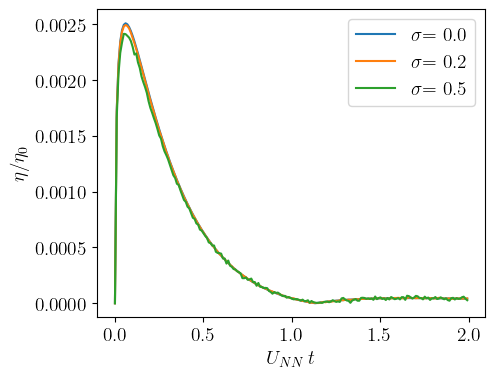

In [ ]:
plt.figure(figsize=(5,4))

for i in range(len(etat_3s)):
    plt.plot(tdar, np.abs(etat_3s[i]), label=r'$\sigma$= {}'.format(sigmas[i]))

plt.xlabel(Ust+r"$\,t$", fontsize=14)
plt.ylabel(r"$\eta/\eta_0$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [ ]:
# eta vs t for all n<N, at fixed Ud, sigma and N

Ntubes = N0
ntar = list(range(2, N0 + 1)) if N0 > 2 else [2]
sigma = sigmas[1]
Ud = Uds[1]

eta_n = [[] for _ in range(len(ntar))]
etat_n = [[] for _ in range(len(ntar))]
visc0_kx = [[] for _ in range(len(ntar))]
visc_kx_all = [[[] for _ in range(len(tdar))] for _ in range(len(ntar))]

# Precompute visc0_kx
for i, n in enumerate(ntar):
    for kx in tqdm(kxar):
        visc0_kx[i].append(eta0Disr(Ndisr, Ntubes, kx, Uc, Ud, sigma, 1, n))

# Precompute visc_kx for all t and n
for j, n in enumerate(ntar):
    for i, t in enumerate(tdar):
        for kx in tqdm(kxar):
            visc_kx_all[j][i].append(etatDisr(Ndisr, Ntubes, kx, Uc, Ud, sigma, 1, n, t))

# Compute eta_n and etat_n
for j, n in enumerate(ntar):
    for i, t in enumerate(tdar):
        eta_n[j].append(np.trapz(visc_kx_all[j][i], kxar) / np.trapz(visc0_kx[j], kxar))
        etat_n[j].append(np.trapz(visc_kx_all[j][i], kxar))

100%|██████████| 1000/1000 [00:00<00:00, 2403.81it/s]


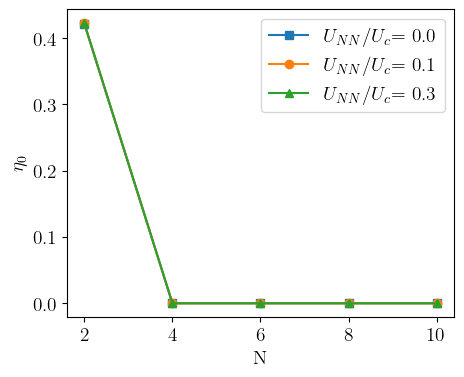

In [ ]:
plt.figure(figsize=(5,4))

for i in range(len(eta_n)):
    plt.plot(tdar, eta_n[i], label=f'n = {ntar[i]}', marker=markers[i])

plt.xlabel(r't', fontsize=14)
plt.ylabel(r"$\eta/\eta_0$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()